In [1]:
# !pip install protobuf==3.20.1

In [2]:
# from sagemaker.xgboost.estimator import XGBoost
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### data + dates

In [3]:
test_date = '2024-10-01'

In [4]:
df = pd.read_parquet('s3://sisyphus-general-bucket/AthenaInsights/latest_data/model/data/stock_bars_1min.parquet' )

In [5]:
category_map = {'A': 0, 'B': 1, 'C':2}
reverse_category_map = {v: k for k, v in category_map.items()}

In [6]:
df = df.fillna(0)
df['mapped_category'] = df['category'].map({'A': 0, 'B': 1, 'C':2})
df['mapped_category'].value_counts()

mapped_category
2    192523
0     12361
1      9910
Name: count, dtype: int64

### train test split

In [53]:
X_train = df.loc[:'2024-09-30', ].drop(columns=['category', 'mapped_category'])
y_train = df.loc[:'2024-09-30', 'mapped_category'] # ['category']

X_test = df.loc['2024-10-01': '2024-10-10', ].drop(columns=['category', 'mapped_category'])
y_test = df.loc['2024-10-01': '2024-10-10', 'mapped_category'] # ['category']

X_test_full = df.loc['2024-10-01':, ].drop(columns=['category', 'mapped_category'])
y_test_full = df.loc['2024-10-01':, 'mapped_category'] # ['category']

X_test_only_next_day = df.loc['2024-10-01': '2024-10-01', ].drop(columns=['category', 'mapped_category'])
y_test_only_next_day = df.loc['2024-10-01': '2024-10-01', 'mapped_category'] # ['category']

In [8]:
y_train.value_counts()

mapped_category
2    161282
0     10399
1      8554
Name: count, dtype: int64

In [9]:
y_test.value_counts()

mapped_category
2    6809
0     523
1     348
Name: count, dtype: int64

In [10]:
y_test_full.value_counts()

mapped_category
2    31241
0     1962
1     1356
Name: count, dtype: int64

In [11]:
y_test_only_next_day.value_counts()

mapped_category
2    1649
0     163
1     108
Name: count, dtype: int64

### training the model

In [12]:
# Training the model
clf = xgb.XGBClassifier(n_estimators=100,
                        objective='multi:softmax',
                        n_jobs =-1,
                        random_state=420,
                        num_class=3,
                        eval_metric=['merror','mlogloss'])
clf.fit(X_train,
        y_train,
        verbose=1,
        eval_set=[(X_train, y_train), (X_test, y_test), (X_test_full, y_test_full), (X_test_only_next_day, y_test_only_next_day)])
# bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'test')], early_stopping_rounds=10)

[0]	validation_0-merror:0.10123	validation_0-mlogloss:0.79794	validation_1-merror:0.11146	validation_1-mlogloss:0.80142	validation_2-merror:0.09627	validation_2-mlogloss:0.79561	validation_3-merror:0.14115	validation_3-mlogloss:0.82147
[1]	validation_0-merror:0.10157	validation_0-mlogloss:0.62643	validation_1-merror:0.11328	validation_1-mlogloss:0.63371	validation_2-merror:0.09668	validation_2-mlogloss:0.62250	validation_3-merror:0.14115	validation_3-mlogloss:0.66550
[2]	validation_0-merror:0.10085	validation_0-mlogloss:0.51711	validation_1-merror:0.11172	validation_1-mlogloss:0.52833	validation_2-merror:0.09584	validation_2-mlogloss:0.51781	validation_3-merror:0.13906	validation_3-mlogloss:0.57023
[3]	validation_0-merror:0.10075	validation_0-mlogloss:0.44365	validation_1-merror:0.11198	validation_1-mlogloss:0.46047	validation_2-merror:0.09633	validation_2-mlogloss:0.44605	validation_3-merror:0.13854	validation_3-mlogloss:0.50706
[4]	validation_0-merror:0.10069	validation_0-mlogloss:0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)

### results

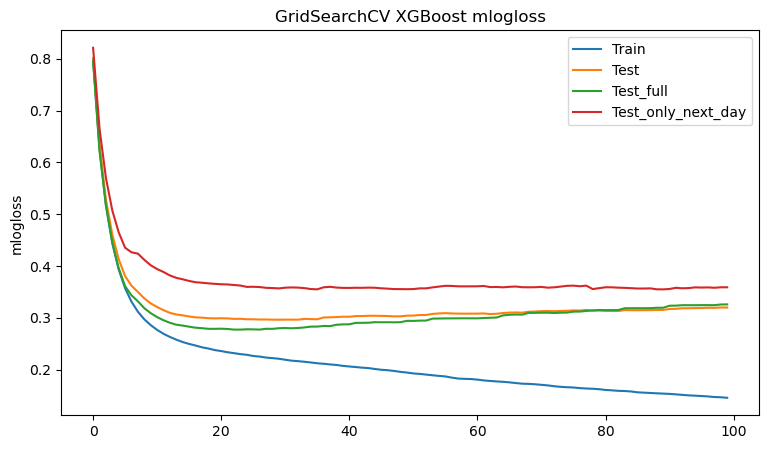

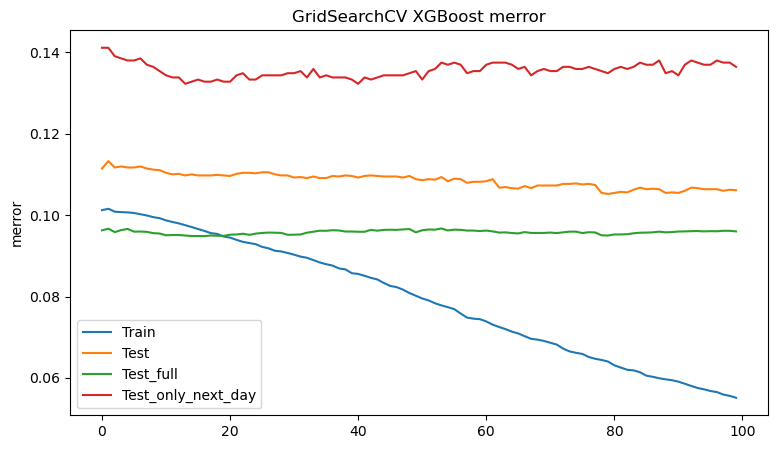

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# clf.evals_result()
# preparing evaluation metric plots
results = clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.plot(x_axis, results['validation_2']['mlogloss'], label='Test_full')
ax.plot(x_axis, results['validation_3']['mlogloss'], label='Test_only_next_day')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.plot(x_axis, results['validation_2']['merror'], label='Test_full')
ax.plot(x_axis, results['validation_3']['merror'], label='Test_only_next_day')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [14]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[ 134    0  389]
 [   0   24  324]
 [  68   34 6707]]

-------------------- Key Metrics --------------------

Accuracy: 0.89
Balanced Accuracy: 0.44

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.66
Macro Recall: 0.44
Macro F1-score: 0.48

Weighted Precision: 0.87
Weighted Recall: 0.89
Weighted F1-score: 0.87

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.66      0.26      0.37       523
           1       0.41      0.07      0.12       348
           2       0.90      0.99      0.94      6809

    accuracy                           0.89      7680
   macro avg       0.66      0.44      0.48      7680
weighted avg       0.87      0.89      0.87      7680

---------------------- XGBoost ----------------------


In [15]:
# y_test.value_counts() # category # 2    6809 # 0     523 # 1     348
# 134 + 0 + 389 # 0
# 0 + 24 + 324 # 1
# 68 + 34 + 6707 # 2

6809

In [16]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred_full = clf.predict(X_test_full)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test_full, y_pred_full))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test_full, y_pred_full)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test_full, y_pred_full)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_full, y_pred_full, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_full, y_pred_full, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_full, y_pred_full, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_full, y_pred_full, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_full, y_pred_full, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_full, y_pred_full, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_full, y_pred_full, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_full, y_pred_full, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_full, y_pred_full, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test_full, y_pred_full))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[  198     0  1764]
 [    0    60  1296]
 [  135   123 30983]]

-------------------- Key Metrics --------------------

Accuracy: 0.90
Balanced Accuracy: 0.38

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.61
Macro Recall: 0.38
Macro F1-score: 0.40

Weighted Precision: 0.87
Weighted Recall: 0.90
Weighted F1-score: 0.87

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.59      0.10      0.17      1962
           1       0.33      0.04      0.08      1356
           2       0.91      0.99      0.95     31241

    accuracy                           0.90     34559
   macro avg       0.61      0.38      0.40     34559
weighted avg       0.87      0.90      0.87     34559

---------------------- XGBoost ----------------------


In [17]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred_only_next_day = clf.predict(X_test_only_next_day)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test_only_next_day, y_pred_only_next_day))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test_only_next_day, y_pred_only_next_day)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test_only_next_day, y_pred_only_next_day)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_only_next_day, y_pred_only_next_day, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_only_next_day, y_pred_only_next_day, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_only_next_day, y_pred_only_next_day, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_only_next_day, y_pred_only_next_day, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_only_next_day, y_pred_only_next_day, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_only_next_day, y_pred_only_next_day, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_only_next_day, y_pred_only_next_day, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_only_next_day, y_pred_only_next_day, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_only_next_day, y_pred_only_next_day, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test_only_next_day, y_pred_only_next_day))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[  51    0  112]
 [   0   14   94]
 [  32   24 1593]]

-------------------- Key Metrics --------------------

Accuracy: 0.86
Balanced Accuracy: 0.47

Micro Precision: 0.86
Micro Recall: 0.86
Micro F1-score: 0.86

Macro Precision: 0.62
Macro Recall: 0.47
Macro F1-score: 0.51

Weighted Precision: 0.83
Weighted Recall: 0.86
Weighted F1-score: 0.84

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.61      0.31      0.41       163
           1       0.37      0.13      0.19       108
           2       0.89      0.97      0.92      1649

    accuracy                           0.86      1920
   macro avg       0.62      0.47      0.51      1920
weighted avg       0.83      0.86      0.84      1920

---------------------- XGBoost ----------------------


### analysis

In [54]:
preds_probs = clf.predict_proba(X_test_only_next_day)

for i in range(4, 10, 1):
    preds_probs1 = (preds_probs>=i/10).argmax(axis=1,)
    print(i/10)
    print(confusion_matrix(y_test_only_next_day, preds_probs1))
    print('\n')

0.4
[[ 41   0  39]
 [  0  18  49]
 [ 33  20 760]]


0.5
[[ 36   0  44]
 [  2  13  52]
 [ 24  10 779]]


0.6
[[ 42   0  38]
 [ 12   8  47]
 [ 50   5 758]]


0.7
[[ 51   0  29]
 [ 29   3  35]
 [ 80   2 731]]


0.8
[[ 62   0  18]
 [ 34   0  33]
 [119   1 693]]


0.9
[[ 77   0   3]
 [ 42   0  25]
 [198   0 615]]




<Axes: >

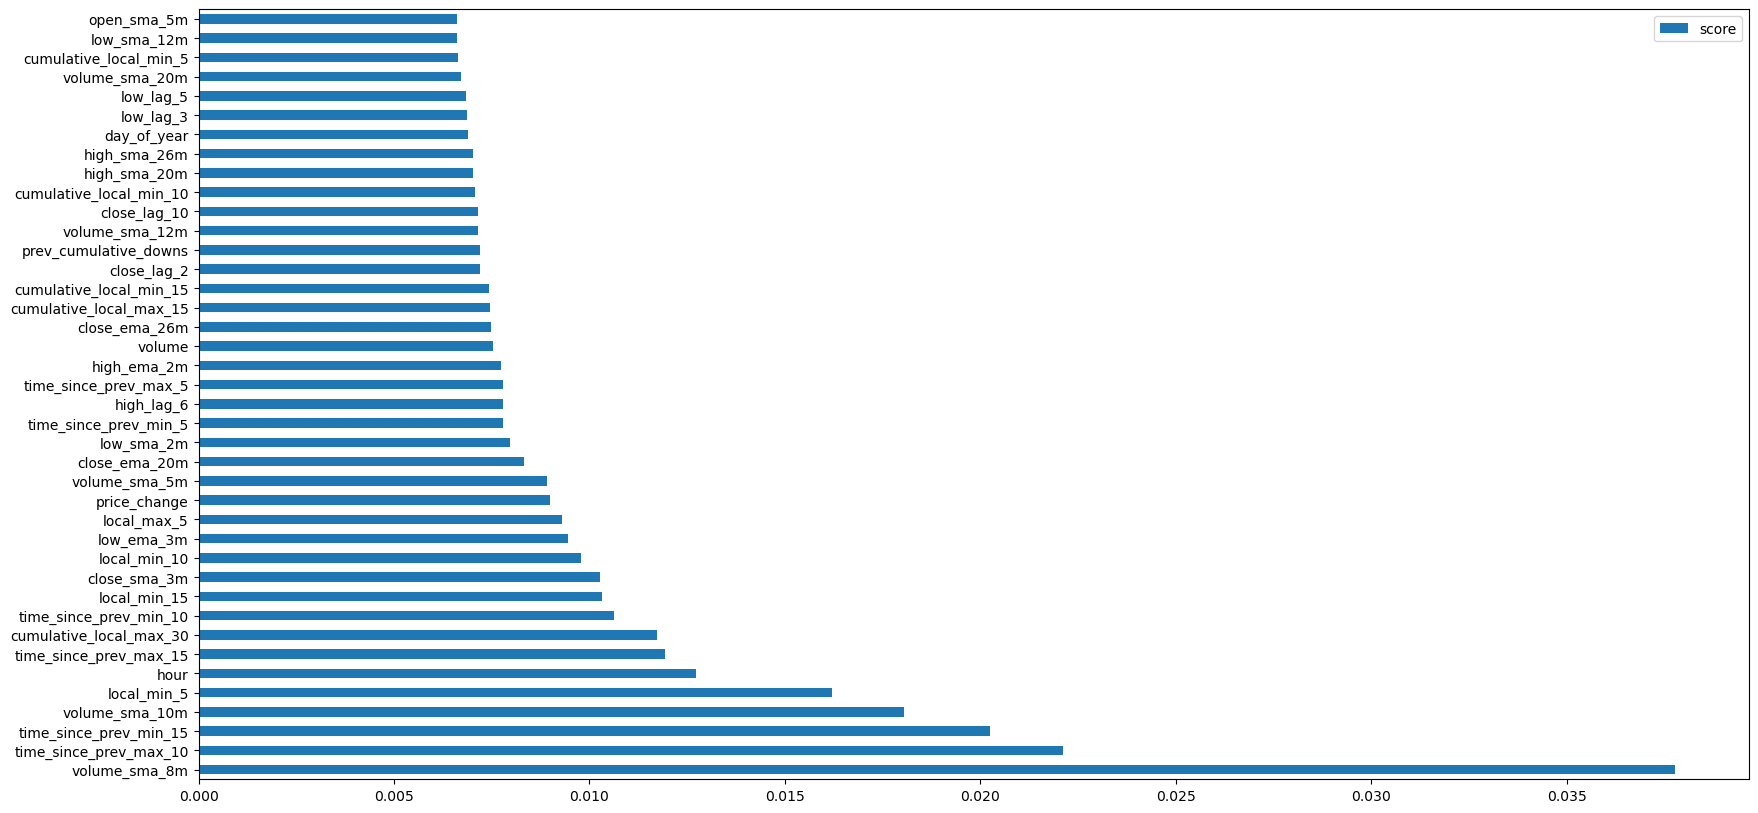

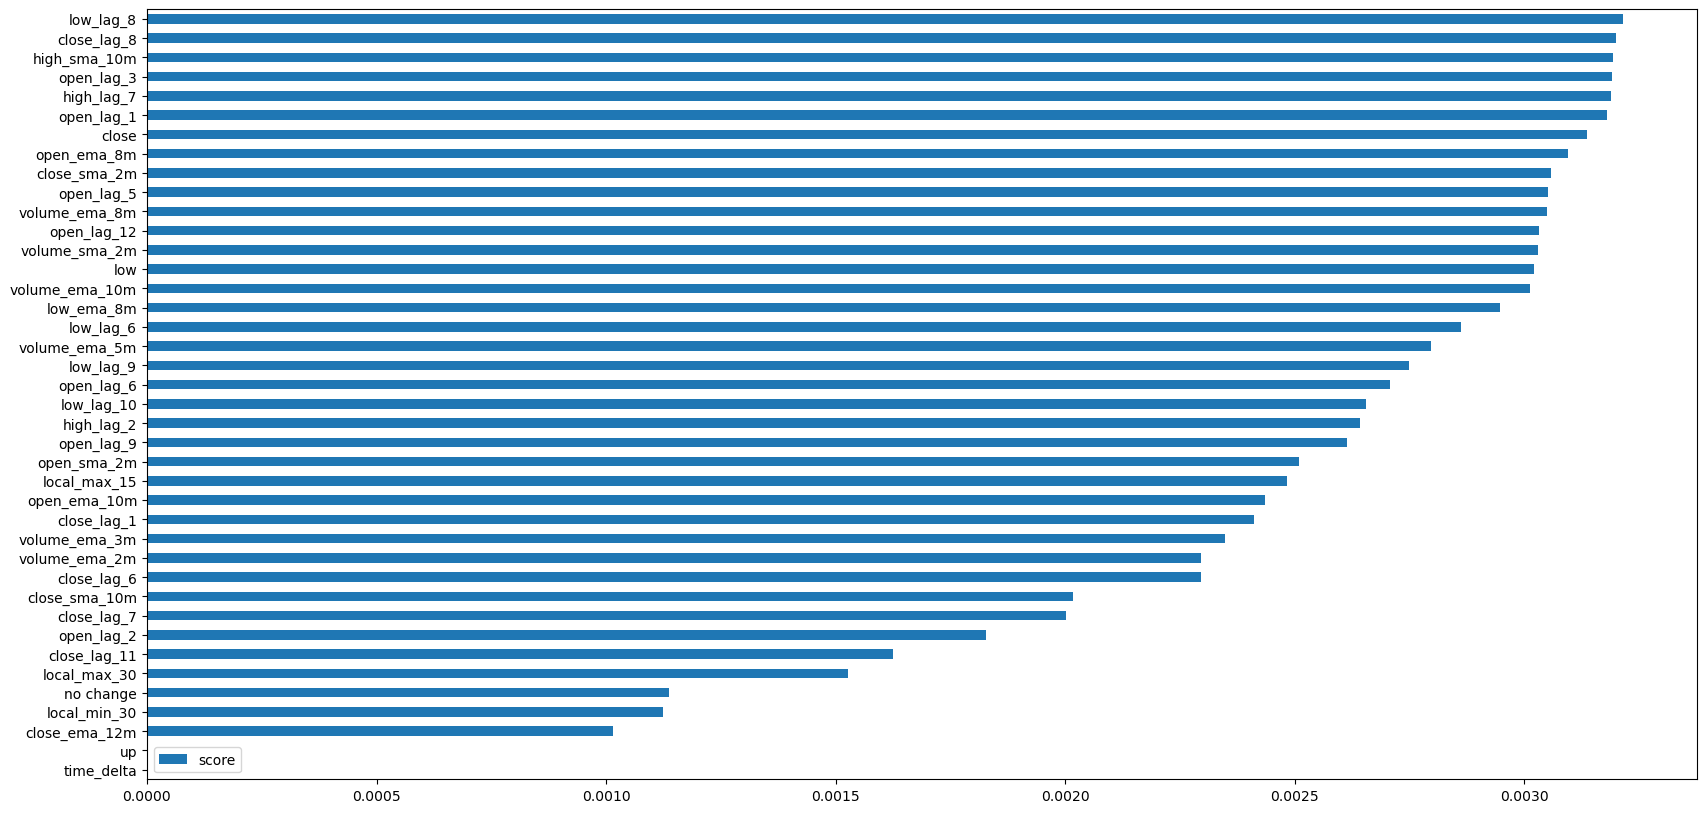

In [55]:
feature_important = clf.feature_importances_ 
keys = list(X_train.columns)
values = list(feature_important)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
data.nsmallest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [77]:
def plot_categorization(df, date, pred, field='close', ):
    """ Plot categorization for a given day with dynamic field selection """
    df_day = df.loc[date]
    df_day['preds'] = list(pred)
    # categories, future_highs, future_lows = categorize_points(df_day, field=field, **kwargs)
    # df_day['category'] = categories
    # df_day['future_highs'] = future_highs
    # df_day['future_lows'] = future_lows

    
    plt.figure(figsize=(14, 7))
    plt.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
    # plt.plot(df_day.index, df_day['close'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
    for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
        plt.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=30 if cat!='C' else 0)
    for cat, color in zip(['A', 'B', 'C'], ['blue', 'black', 'pink']):
        print(cat)
        print(df_day[df_day['preds'] == cat].index)
        plt.scatter(df_day[df_day['preds'] == cat].index, df_day[df_day['preds'] == cat][field], color=color, label=f'Preds {cat}', s=20 if cat!='C' else 10, 
                    # marker = '1' if cat=='B' else '2' if cat=='A' else '+')
                    marker='s')
    plt.legend()
    plt.title(f'Price Categorization on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{field.capitalize()} Price')
    plt.show()

/tmp/ipykernel_31487/1380064290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['preds'] = list(pred)


A
DatetimeIndex(['2024-10-01 09:42:00', '2024-10-01 09:43:00',
               '2024-10-01 09:44:00', '2024-10-01 09:49:00',
               '2024-10-01 09:50:00', '2024-10-01 09:53:00',
               '2024-10-01 09:54:00', '2024-10-01 09:55:00',
               '2024-10-01 09:56:00', '2024-10-01 09:57:00',
               '2024-10-01 09:58:00', '2024-10-01 09:59:00',
               '2024-10-01 10:12:00', '2024-10-01 10:13:00',
               '2024-10-01 10:14:00', '2024-10-01 10:15:00',
               '2024-10-01 10:17:00', '2024-10-01 10:18:00',
               '2024-10-01 10:19:00', '2024-10-01 10:20:00',
               '2024-10-01 10:21:00', '2024-10-01 10:22:00',
               '2024-10-01 10:25:00', '2024-10-01 10:29:00',
               '2024-10-01 10:30:00', '2024-10-01 10:32:00',
               '2024-10-01 10:33:00', '2024-10-01 10:34:00',
               '2024-10-01 10:35:00', '2024-10-01 10:36:00',
               '2024-10-01 10:37:00', '2024-10-01 10:38:00',
               '2024-1

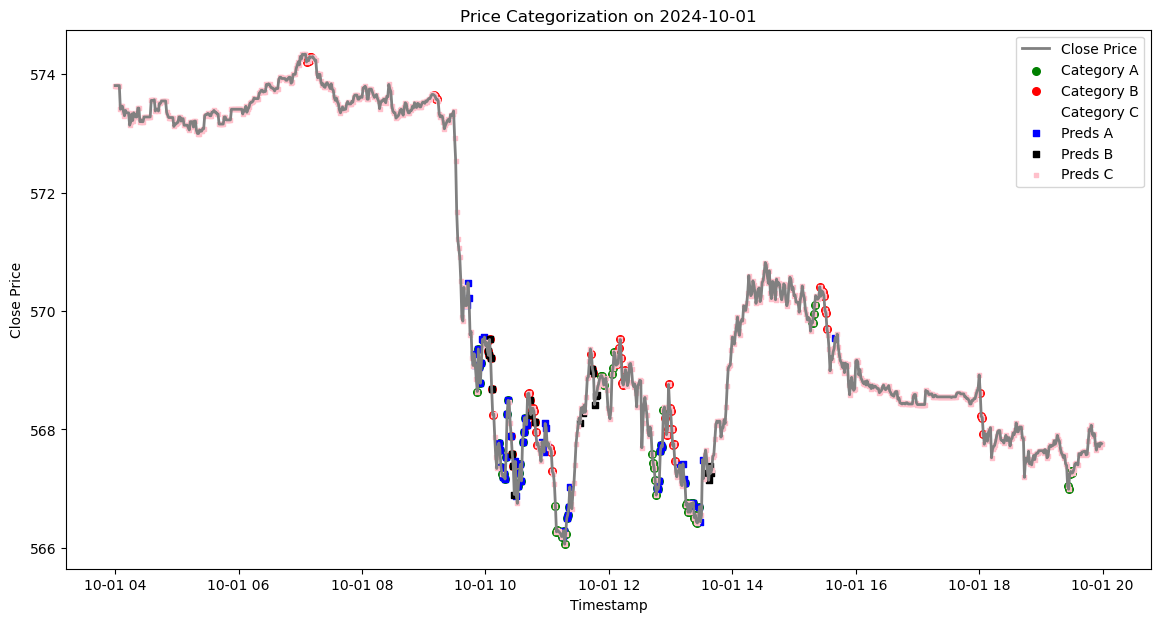

In [78]:
preds_probs = clf.predict_proba(X_test_only_next_day)
preds_probs1 = (preds_probs>=0.5).argmax(axis=1,)
plot_categorization(df, '2024-10-01', pd.Series(preds_probs1).map(reverse_category_map))

In [79]:
df['up'].value_counts()

up
0    130431
1     84363
Name: count, dtype: int64

In [50]:
preds_probs1.shape

(1920,)